# Bitcoin Trading – Dimensionality Reduction

Clean, ready-to-run notebook (Google Colab)


## 0. Setup

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

import warnings
warnings.filterwarnings('ignore')


## 1. Load data

In [4]:

# Dataset download (alternative direct load via KaggleHub)
# 1. Load data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlfinancebook/bitstamp-bicoin-minutes-data")

print("Path to dataset files:", path)

dataset = pd.read_csv(path + "/BitstampData.csv")

print(dataset.shape)
dataset.tail()

# 1.1 Quick NA check and descriptive stats
print("Any NA? ->", dataset.isnull().values.any())
display(dataset.describe().T)


Using Colab cache for faster access to the 'bitstamp-bicoin-minutes-data' dataset.
Path to dataset files: /kaggle/input/bitstamp-bicoin-minutes-data
(2841377, 8)
Any NA? -> True


,count,mean,std,min,25%,50%,75%,max
Timestamp,2841377.0,1.410731e+09,4.938008e+07,1.325318e+09,1.367939e+09,1.410559e+09,1.453568e+09,1.496189e+09
Open,1650904.0,4.958926e+02,3.642453e+02,3.800000e+00,2.399300e+02,4.199800e+02,6.410000e+02,2.754740e+03
High,1650904.0,4.962309e+02,3.645454e+02,3.800000e+00,2.400000e+02,4.200000e+02,6.417200e+02,2.760100e+03
Low,1650904.0,4.955310e+02,3.639298e+02,1.500000e+00,2.398300e+02,4.198500e+02,6.401825e+02,2.752000e+03
Close,1650904.0,4.958933e+02,3.642512e+02,1.500000e+00,2.399300e+02,4.199800e+02,6.410000e+02,2.754820e+03
Volume_(BTC),1650904.0,1.188361e+01,4.093656e+01,0.000000e+00,3.827502e-01,1.823000e+00,8.028465e+00,5.853852e+03
Volume_(Currency),1650904.0,5.316276e+03,1.998227e+04,0.000000e+00,1.239502e+02,6.145704e+02,3.107853e+03,1.865889e+06
Weighted_Price,1650904.0,4.958701e+02,3.642271e+02,3.800000e+00,2.399200e+02,4.199668e+02,6.409529e+02,2.754499e+03


## 2. Cleaning & Label

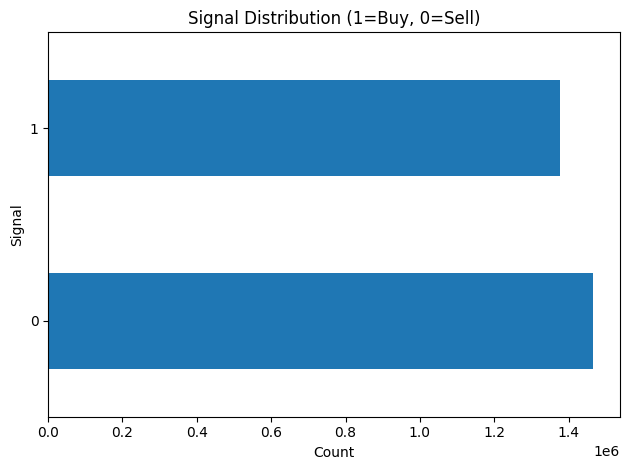

Buy frequency: 48.44%


In [8]:

# 2. Clean & drop timestamp
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

if 'Timestamp' in dataset.columns:
    dataset = dataset.drop(columns=['Timestamp'])

# 2.1 Create short/long MAs and the binary signal

dataset['short_mavg'] = dataset['Close'].rolling(10, min_periods=1).mean()
dataset['long_mavg']  = dataset['Close'].rolling(60, min_periods=1).mean()
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1, 0)

dataset[['Close','short_mavg','long_mavg','signal']].tail()

# 2.2 Class balance visual
fig = plt.figure()
dataset.groupby('signal').size().plot(kind='barh')
plt.title('Signal Distribution (1=Buy, 0=Sell)')
plt.xlabel('Count'); plt.ylabel('Signal'); plt.tight_layout()
plt.show()

buy_share = 100 * dataset['signal'].mean()
print(f"Buy frequency: {buy_share:.2f}%")


## 3. Feature Engineering

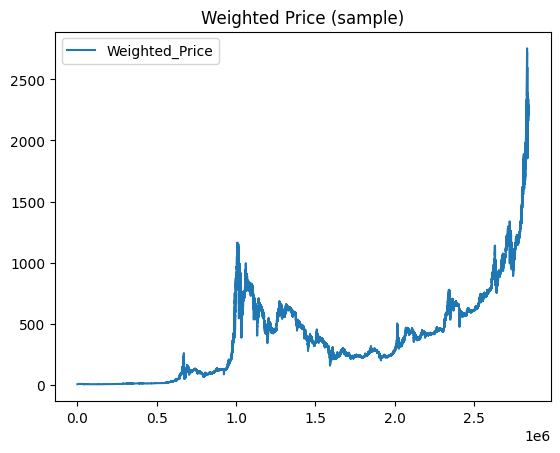

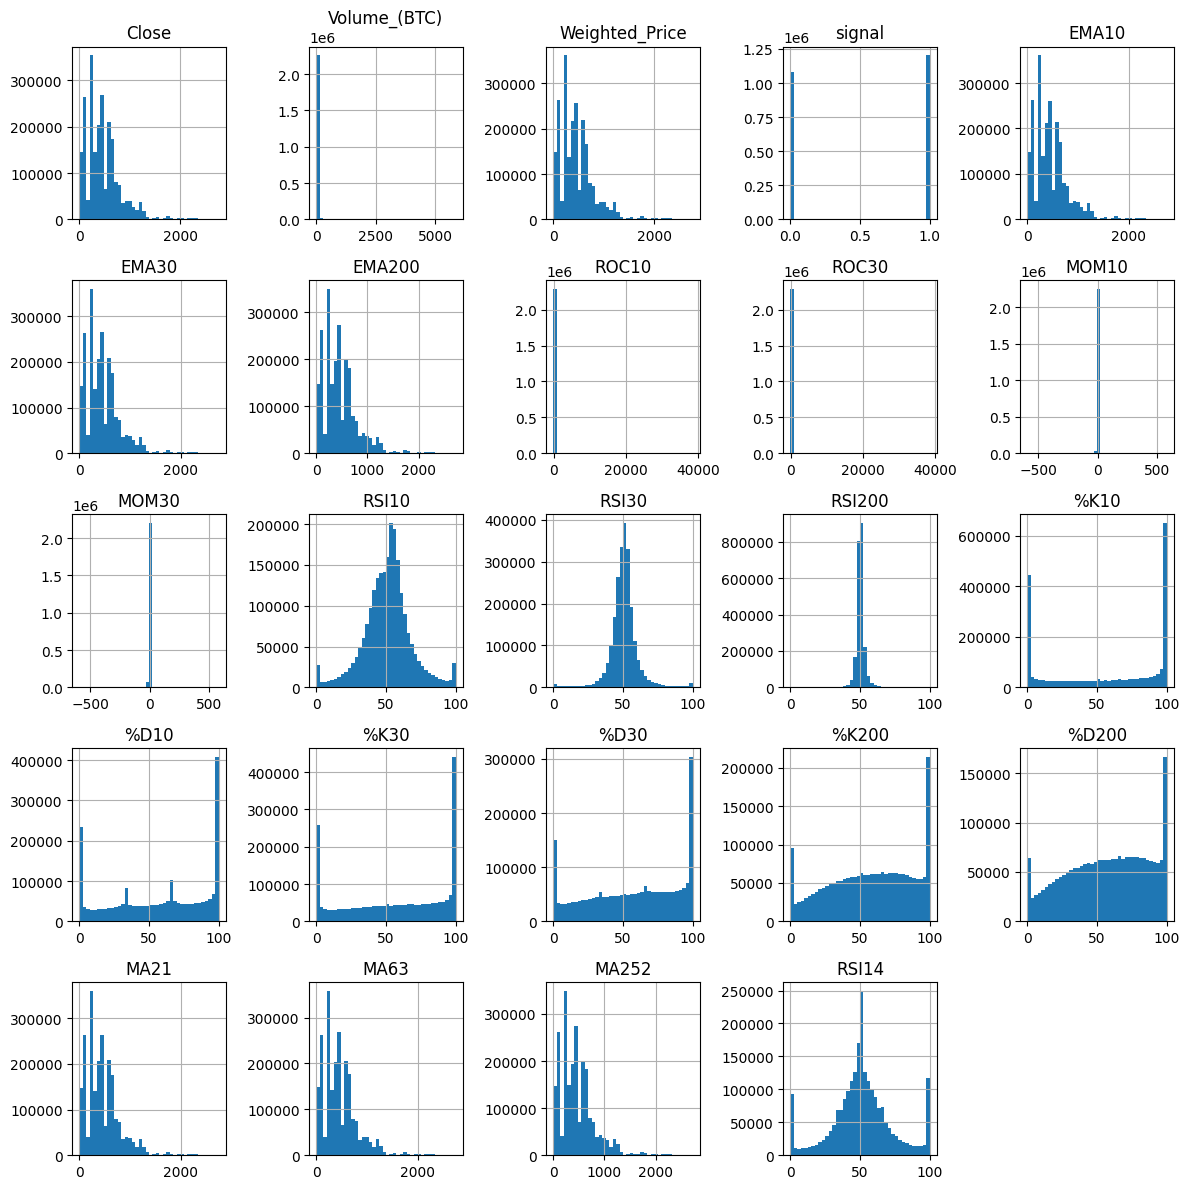

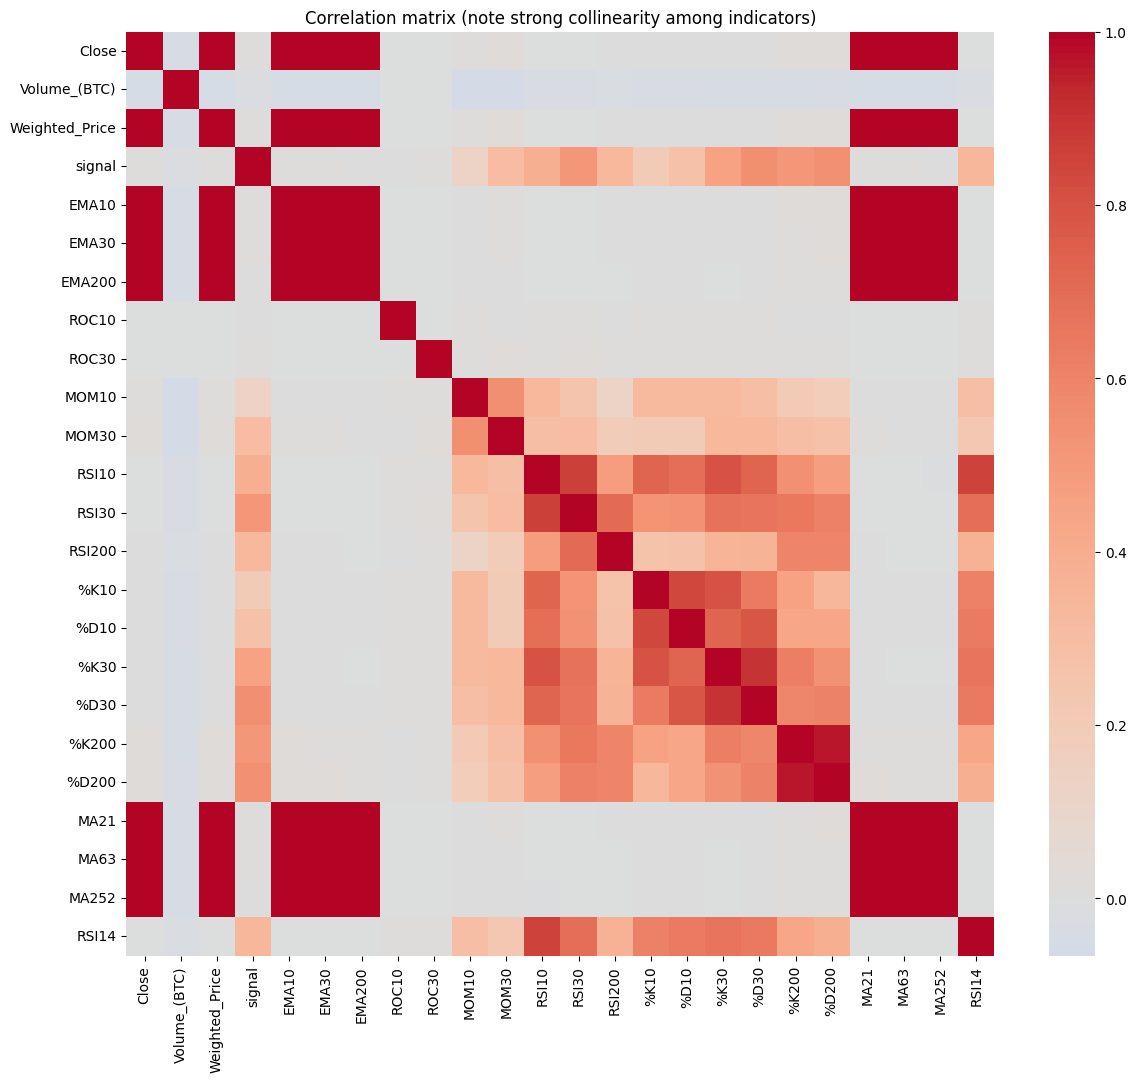

(2841377, 30)


In [11]:
# EMA
def EMA(df, n):
    return pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name=f'EMA_{n}')

# ROC
def ROC(series, n):
    M = series.diff(n - 1)
    N = series.shift(n - 1)
    return pd.Series(((M / N) * 100), name=f'ROC_{n}')

# Momentum
def MOM(series, n):
    return pd.Series(series.diff(n), name=f'Momentum_{n}')

# RSI
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta.clip(lower=0)
    d = (-delta).clip(lower=0)
    u.iloc[period-1] = u.iloc[:period].mean()
    d.iloc[period-1] = d.iloc[:period].mean()
    u = u.iloc[period-1:].ewm(com=period-1, adjust=False).mean()
    d = d.iloc[period-1:].ewm(com=period-1, adjust=False).mean()
    rs = u / d
    rsi = 100 - (100 / (1 + rs))
    rsi.index = series.index[-len(rsi):]
    return rsi.rename(f'RSI_{period}')

# Stochastic Oscillator %K and %D
def STOK(close, low, high, n):
    return ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100

def STOD(close, low, high, n):
    return STOK(close, low, high, n).rolling(3).mean()

# Simple MA
def MA(df, n):
    return pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name=f'MA_{n}')

# Compute indicators
dataset['EMA10']  = EMA(dataset, 10)
dataset['EMA30']  = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)

dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

dataset['RSI10']  = RSI(dataset['Close'], 10)
dataset['RSI30']  = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

dataset['%K10']   = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10']   = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30']   = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30']   = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200']  = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200']  = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

dataset['MA21']  = MA(dataset, 21)
dataset['MA63']  = MA(dataset, 63)
dataset['MA252'] = MA(dataset, 252)

# Clean up columns we won't use for modeling directly
dataset_model = dataset.drop(columns=['Open','High','Low','Volume_(Currency)','short_mavg','long_mavg'], errors='ignore')
dataset_model = dataset_model.dropna()

dataset_model.tail()
dataset_model[['Weighted_Price']].plot(title='Weighted Price (sample)')
plt.show()
dataset_model.hist(bins=40, figsize=(12, 12))
plt.tight_layout(); plt.show()

corr = dataset_model.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation matrix (note strong collinearity among indicators)')
plt.show()

# Check class balance again after dropna
(dataset_model['signal'].value_counts(normalize=True) * 100).round(2)
print(dataset.shape)


## 4. Train-test split

In [12]:
# split out validation dataset for the end
subset_dataset = dataset_model.iloc[-100000:]  # last 100k rows slice
subset_dataset.dropna(how='any', inplace=True)
Y = subset_dataset["signal"]
X = subset_dataset.loc[:, dataset_model.columns != 'signal']

validation_size = 0.2
seed = 1

from sklearn.model_selection import train_test_split
X_train, X_validation, Y_train, Y_validation = train_test_split(
    X, Y, test_size=validation_size, random_state=1
)

X_train.shape, X_validation.shape, Y_train.mean().round(3), Y_validation.mean().round(3)

((80000, 23), (20000, 23), np.float64(0.555), np.float64(0.549))

## 5. Standardization

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
rescaledDataset = pd.DataFrame(
    scaler.fit_transform(X_train),  # original code fits again; kept as-is
    columns=X_train.columns,
    index=X_train.index
)
rescaledDataset.head(2)


,Close,Volume_(BTC),Weighted_Price,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,...,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252,RSI14
2820052,0.524320,0.093645,0.524480,0.519215,0.509915,0.535468,0.781958,0.951880,0.131857,1.067436,...,0.587476,0.542389,1.114114,1.076281,-0.549716,-0.623493,0.511063,0.502996,0.546244,1.004021
2817786,0.790248,-0.394243,0.782194,0.788784,0.784524,0.783661,0.517538,0.287115,0.464181,0.649817,...,0.955050,1.237722,1.136442,1.307673,0.699381,0.741794,0.784225,0.782452,0.778266,0.742850


## 6. SVD

Using Colab cache for faster access to the 'bitstamp-bicoin-minutes-data' dataset.
Path to dataset files: /kaggle/input/bitstamp-bicoin-minutes-data
(2841377, 8)
Any NA? -> True


,count,mean,std,min,25%,50%,75%,max
Timestamp,2841377.0,1.410731e+09,4.938008e+07,1.325318e+09,1.367939e+09,1.410559e+09,1.453568e+09,1.496189e+09
Open,1650904.0,4.958926e+02,3.642453e+02,3.800000e+00,2.399300e+02,4.199800e+02,6.410000e+02,2.754740e+03
High,1650904.0,4.962309e+02,3.645454e+02,3.800000e+00,2.400000e+02,4.200000e+02,6.417200e+02,2.760100e+03
Low,1650904.0,4.955310e+02,3.639298e+02,1.500000e+00,2.398300e+02,4.198500e+02,6.401825e+02,2.752000e+03
Close,1650904.0,4.958933e+02,3.642512e+02,1.500000e+00,2.399300e+02,4.199800e+02,6.410000e+02,2.754820e+03
Volume_(BTC),1650904.0,1.188361e+01,4.093656e+01,0.000000e+00,3.827502e-01,1.823000e+00,8.028465e+00,5.853852e+03
Volume_(Currency),1650904.0,5.316276e+03,1.998227e+04,0.000000e+00,1.239502e+02,6.145704e+02,3.107853e+03,1.865889e+06
Weighted_Price,1650904.0,4.958701e+02,3.642271e+02,3.800000e+00,2.399200e+02,4.199668e+02,6.409529e+02,2.754499e+03


Variance preserved by first 5 components == 89.18%


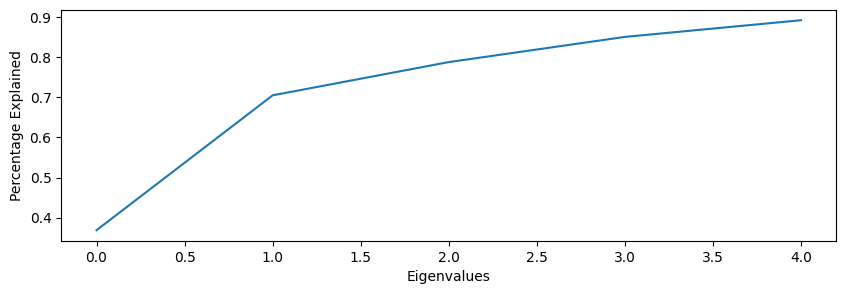

In [18]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlfinancebook/bitstamp-bicoin-minutes-data")

print("Path to dataset files:", path)

dataset = pd.read_csv(path+'/'+'BitstampData.csv')


print(dataset.shape)
dataset.tail()

# 1.1 Quick NA check and descriptive stats
print("Any NA? ->", dataset.isnull().values.any())
display(dataset.describe().T)
from sklearn.decomposition import TruncatedSVD

ncomps = 5
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(rescaledDataset)
Y_pred = svd.fit_transform(rescaledDataset)  # respecting the original code

ax = pd.Series(svd_fit.explained_variance_ratio_.cumsum()).plot(
    kind='line', figsize=(10, 3)
)
ax.set_xlabel("Eigenvalues")
ax.set_ylabel("Percentage Explained")

print('Variance preserved by first 5 components == {:.2%}'.format(
    svd_fit.explained_variance_ratio_.cumsum()[-1]
))


##Build a DataFrame for the SVD features

In [20]:
dfsvd = pd.DataFrame(
 Y_pred, columns=['c{}'.format(c) for c in range(ncomps)],
 index=rescaledDataset.index)
print(dfsvd.shape)
dfsvd.head()

(80000, 5)


,c0,c1,c2,c3,c4
2820052,2.401214,-0.224763,-1.782283,0.389250,0.401002
2817786,3.533124,-0.128934,-0.553055,-0.561583,-0.531252
2828308,0.050190,4.919865,1.424070,0.401129,-0.487780
2798786,0.742175,-1.722721,-1.611631,-0.178701,-0.081053
2775835,-0.315673,-2.228615,1.275104,-0.053695,-0.207831


##Pairs plots


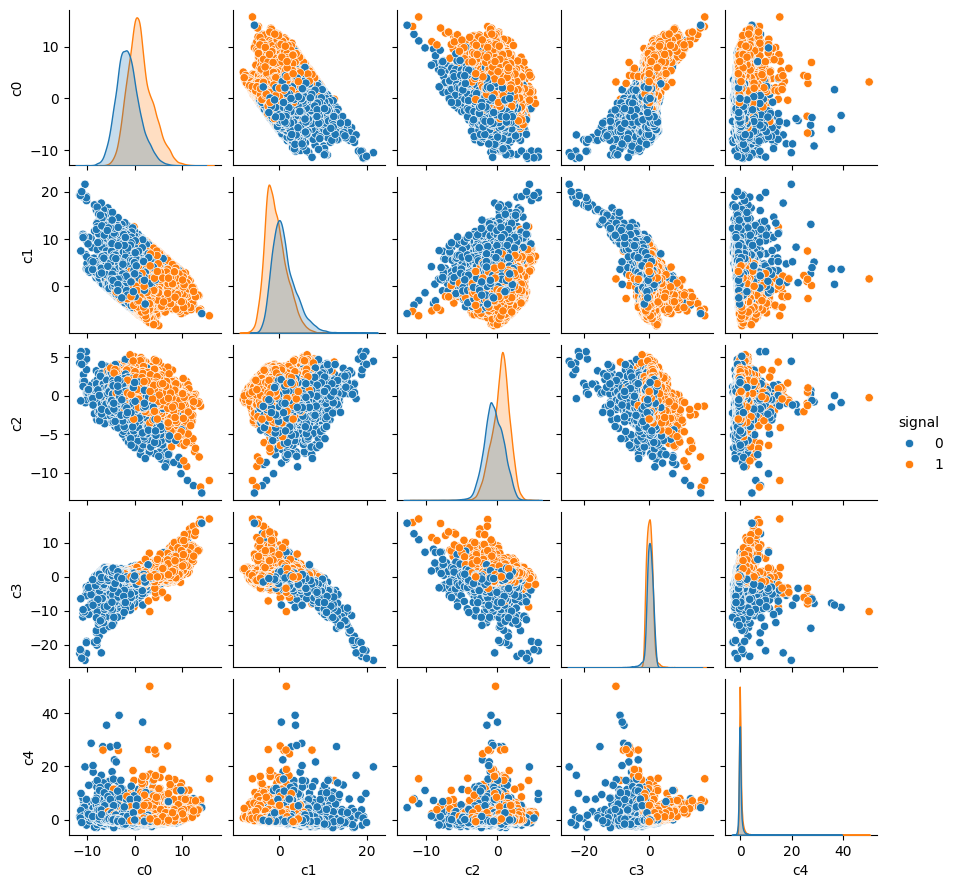

In [29]:
svdcols = [c for c in dfsvd.columns if c[0] == 'c']

plotdims = 5
ploteorows = 1
dfsvdplot = dfsvd[svdcols].iloc[:, :plotdims].copy()
dfsvdplot['signal'] = Y_train  # associate labels

ax = sns.pairplot(dfsvdplot.iloc[::ploteorows, :], hue='signal', height=1.8)

##t-SNE visualization of compressed features

In [23]:
tsne = TSNE(n_components=2, random_state=0)
Z = tsne.fit_transform(dfsvd[svdcols])

dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)
dftsne['signal'] = Y_train

g = sns.lmplot(data=dftsne,x='x', y='y', hue='signal', fit_reg=False, height=8,
               scatter_kws={'alpha':0.7,'s':60})

KeyboardInterrupt: 

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
Z = tsne.fit_transform(dfsvd[svdcols])

dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)
dftsne['signal'] = Y_train

g = sns.lmplot(data=dftsne,x='x', y='y', hue='signal', fit_reg=False, height=8,
               scatter_kws={'alpha':0.7,'s':60})

##Runtime & accuracy with vs. without dimensionality reduction

In [28]:
# test options for classification
scoring = 'accuracy'

import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

start_time = time.time()
models = RandomForestClassifier(n_jobs=-1)

# NOTE: kfold must be defined before use; we follow later definition too, but define a quick one here to time:
kfold = KFold(n_splits=5)  # respecting your style; random_state requires shuffle=True in newer sklearn
cv_results_XTrain = cross_val_score(models, X_train, Y_train, cv=kfold, scoring=scoring)
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
start_time = time.time()
X_SVD = dfsvd[svdcols].iloc[:, :5]
cv_results_SVD = cross_val_score(models, X_SVD, Y_train, cv=kfold, scoring=scoring)
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))


print("Result with dimensionality Reduction: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))


KeyboardInterrupt: 

##Compare multiple algorithms

In [ ]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
# spot check the algorithms
models = []

models.append(('LR', xxx(n_jobs=-1)))
models.append(('LDA', xxx()))
models.append(('KNN', xxx()))
models.append(('CART',xxx())) #  Decision Tree
models.append(('NB', xxx())) Gaussian NB
# Neural Network
models.append(('NN', xxx())) # Multilayer perceptron
# Ensemble Models
# Boosting methods
models.append(('AB', xxx())) #AdaBoost
models.append(('GBM', xxx())) # Gradient Boosting
# Bagging methods
models.append(('RF',xxx(n_jobs=-1)))#  Random Forest
# K-folds cross validation
from sklearn.model_selection import KFold, cross_val_score
results = []
names = []
for name, model in models:
    kfold = xxx(n_splits=num_folds)
    cv_results = xxx(model, rescaledDataset, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()


##Model tuning (Grid Search for Random Forest)

In [ ]:
n_estimators = [20,80]
max_depth = [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)

model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledDataset, Y_train)
# Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

##Finalize the model & evaluate on validation set

In [ ]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80, max_depth=10, n_jobs=-1)
# model = LogisticRegression()  # alternative baseline

model.fit(X_train, Y_train)

# estimate accuracy on validation set
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions = model.predict(X_validation)

print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

# Confusion matrix heatmap
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions),
                     columns=np.unique(Y_validation), index=np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})
plt.show()


##Feature importance (intuition)

In [ ]:
Importance = pd.DataFrame({'Importance': model.feature_importances_ * 100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.title('Random Forest Feature Importance (%)')
plt.show()


##Backtesting (toy)


In [ ]:
# Create column for Strategy Returns using day-ahead (lagged) position
backtestdata = pd.DataFrame(index=X_validation.index)
backtestdata['signal_pred']   = predictions
backtestdata['signal_actual'] = Y_validation

# Market returns from Close
backtestdata['Market Returns']   = X_validation['Close'].pct_change()

# Actual strategy uses the actual label (lagged)
backtestdata['Actual Returns']   = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)

# Our model strategy uses predicted label (lagged)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)

backtestdata = backtestdata.reset_index()
display(backtestdata.head())

# Distribution and cumulative return plots
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
plt.show()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()
plt.title('Cumulative Returns: Strategy vs. “Actual” (toy)')
plt.show()
